<a href="https://colab.research.google.com/github/melisacasella128-hub/dm2025c/blob/main/src/rpart/z201_ComparandoModelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparando Modelos

Estamos en la  Clase 02
<br> El objetivo de la materia es lograr la mejor predicción para nuestro probleama, para lo que se probarán pipelines con decenas de alternativas, será indispensable comparar varios modelos predictivos entre sí y decidir cual es el mejor
<br> La tarea no es tan sencilla

## Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/dm"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dm" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/itba2025-8d0a/dataset_pequeno.csv"
archivo_destino="/content/datasets/dataset_pequeno.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/dataset_pequeno.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


# 1  Particion Training/Testing
## Clase 02  Experimento 1

## 1.1  Objetivos
Dado que es el primer experimento de la asignatura, acercar a l@s estudiantes las mejores prácticas de operación del ambiente de Google Cloud, realizando una minuciosa demostración en vivo narrando todas las consideraciones pertinentes para evitar accidentes, daños a terceros y a equipos.
Dar soporte en el acto a  l@s estudiantes que necesitan ayuda para terminar de configurar el ambiente Google Cloud .
<br>Repaso del concepto de  partición de un dataset al azar, estratificada en la clase
<br>Dado que es el primer script que se mostrará en vivo a l@s estudiantes,  realizar una visita guiada del  mismo, su estructura y detalles.
<br>Repaso del algoritmo Arbol de Decisión sus hiperparámetros, y la implementación con la librería  rpart.  Funciones  rpart::rpart  y rpart::predict
<br>Concepto de replicabilidad de los experimentos mediante las semillas de los generadores de secuencias de números pseudoaleatorios.
<br>Finalmente, el principal objetivo de este experimento es lograr que l@s estudiantes dimensionen la enorme variabilidad del error de medición de la ganancia de un árbol de decisión al realizar una partición <training, testing>,  contener la sorpresa de los estudiantes, descartar a la simple particion <training, testing> como método,  y construir en conjunto una solucion natural al problema.

## 1.2 Introduccion

![Particiohn Training/Testing](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E1_particion.jpg)

![Dos tipos de error](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E1_target.jpg)

## 1.3  Bibliografía

Demšar, J. [Statistical comparisons of classifiers over multiple data sets](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf) J. Mach. Learn. Res. 7, 1–30 (2006).   
Starmer, J. [Machine Learning Fundamentals: Cross Validation](https://www.youtube.com/watch?v=fSytzGwwBVw)Machine Learning Fundamentals: Cross Validation, StatQuest with Josh Starmer youtube channel, (2018)
Hastie, T.[The elements of statistical learning: data mining, inference, and prediction](https://hastie.su.domains/Papers/ESLII.pdf) , volume 2. Springer, 2009  ( Chapter 7 Model Assessment and Selection )

## 1.4 Codigo

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657219,35.1,1454477,77.7,1326038,70.9
Vcells,1220161,9.4,8388608,64.0,1975136,15.1


In [2]:
Sys.time()

[1] "2025-11-16 22:41:26 UTC"

* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [3]:
# cargo las librerias que necesito
require("data.table")
require("rpart")


Loading required package: data.table

Loading required package: rpart



###  Accion a Realizar
PARAM$semilla  debe tener su primer semilla aleatoria

In [20]:
PARAM <- list()
PARAM$semilla <- 100019  # aqui debe ir su primer semilla
PARAM$training_pct <- 70L  # entre  1L y 99L

PARAM$rpart <- list (
  "cp" = -1, # complejidad minima
  "minsplit" = 170, # minima cantidad de regs en un nodo para hacer el split
  "minbucket" = 70, # minima cantidad de regs en una hoja
  "maxdepth" = 7 # profundidad máxima del arbol
)


In [21]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [22]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp201"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [23]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [24]:
# particiono estratificadamente el dataset 70%, 30%
particionar(dataset,
  division = c(PARAM$training_pct, 100L -PARAM$training_pct),
  agrupa = "clase_ternaria",
  seed = PARAM$semilla # aqui se usa SU semilla
)



In [25]:
# genero el modelo
# quiero predecir clase_ternaria a partir del resto
# fold==1  es training,  el 70% de los datos
modelo <- rpart("clase_ternaria ~ .",
  data = dataset[fold == 1],  # fold==1  es training, el 70% de los datos
  xval = 0,
  control = PARAM$rpart # aqui van los parametros
)


In [26]:
# aplico el modelo a los datos de testing
prediccion <- predict(modelo, # el modelo que genere recien
  dataset[fold == 2], # fold==2  es testing, el 30% de los datos
  type = "prob"
) # type= "prob"  es que devuelva la probabilidad


In [27]:
tb_prediccion <- as.data.table(list(
  "clase_ternaria"=dataset[fold == 2, clase_ternaria],
  "prob"=prediccion[, "BAJA+2"]
))

In [28]:
# calculo la ganancia de cada registro
tb_prediccion[, ganancia := ifelse(clase_ternaria == "BAJA+2", 780000, -20000)]

In [29]:
# calculo la clase
tb_prediccion[, Predicted := prob > (1/40) ]

In [30]:
ganancia_test <-  tb_prediccion[ Predicted==TRUE,  sum(ganancia)]

In [31]:
# normalizo la ganancia
ganancia_test_normalizada <- ganancia_test / (( 100 - PARAM$training_pct ) / 100 )

In [32]:
estimulos <- tb_prediccion[ Predicted==TRUE, .N]
aciertos <- tb_prediccion[ Predicted & clase_ternaria == "BAJA+2", .N]


In [33]:
# Resultado Final
cat("Testing total: ", dataset[fold == 2, .N], "\n")
cat("Testing BAJA+2: ", dataset[fold == 2 & clase_ternaria == "BAJA+2", .N], "\n")

cat("Estimulos: ", estimulos, "\n")
cat("Aciertos (BAJA+2): ", aciertos, "\n")

cat("Ganancia en testing (normalizada): ", ganancia_test_normalizada, "\n")


Testing total:  49376 
Testing BAJA+2:  370 
Estimulos:  2650 
Aciertos (BAJA+2):  177 
Ganancia en testing (normalizada):  295333333 


### Acciones a realizar
* Reportar la  *Ganancia en testing (normalizada)* <br> en la planilla colaborativa hoja  **C2-1sem**
* Se discutirá en clase la variabilidad de las ganancias obtenidas de distintos alumnos



---



# 2  Medición Monte Carlo Cross Validation
## Clase 02  Experimento 2

## 2.1  Objetivos
Mostrar el funcionamiento de la Montecarlo Cross Validation y que l@s estudiantes aprecien la disminución de la varianza de dicha metodología.
Relación con el Teorema Central del Límite

## 2.2 Introduccion

![Montecarlo](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E2_montecarlo.jpg)

![Curva normal](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E2_normal.jpg)

![Teorema Central del Limite](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E2_teoremacentralLimite.jpg)



## 2.3  Bibliografía

Demšar, J. [Statistical comparisons of classifiers over multiple data sets](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf) J. Mach. Learn. Res. 7, 1–30 (2006).   
Starmer, J. [Machine Learning Fundamentals: Cross Validation](https://www.youtube.com/watch?v=fSytzGwwBVw)Machine Learning Fundamentals: Cross Validation, StatQuest with Josh Starmer youtube channel, (2018)
Hastie, T.[The elements of statistical learning: data mining, inference, and prediction](https://hastie.su.domains/Papers/ESLII.pdf) , volume 2. Springer, 2009  ( Chapter 7 Model Assessment and Selection )

## 2.4 Codigo  Montecarlo

El código de la Montecarlo Cross Validation es notablemente más complejo que el anterior de una simple partición training/testing
<br> Se crea la funcion ArbolEstimarGanancia()  que dada una semilla realiza la partición  training/testing, entrena en training, aplica el modelo a testing, y se calculan las ganancias
<br> Se utiliza la funcion **mcmapply**  de R para aplicar ArbolEstimarGanancia a todos los elementos del vector de semillas

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [34]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,748053,40.0,1454477,77.7,1454477,77.7
Vcells,1416523,10.9,81574766,622.4,103186563,787.3


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [35]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

###  Accion a Realizar
PARAM$semillas  debe tener sus cinco semillas aleatorias

In [36]:
PARAM <- list()
PARAM$semillas <- c(100019, 250007, 500009, 750019, 800009)  # aqui debe ir sus CINCO
PARAM$training_pct <- 70L  # entre  1L y 99L

PARAM$rpart <- list (
  "cp" = -1, # complejidad minima
  "minsplit" = 170, # minima cantidad de regs en un nodo para hacer el split
  "minbucket" = 70, # minima cantidad de regs en una hoja
  "maxdepth" = 7 # profundidad máxima del arbol
)


In [37]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [38]:

ArbolEstimarGanancia <- function(semilla, param_basicos) {
  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(param_basicos$training_pct, 100L -param_basicos$training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_basicos$rpart
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion <- predict(modelo, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad

  # prediccion es una matriz con TRES columnas,
  #  llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
  # cada columna es el vector de probabilidades


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test <- dataset[
    fold == 2,
    sum(ifelse(prediccion[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada <- ganancia_test / (( 100 - PARAM$training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "testing" = dataset[fold == 2, .N],
    "testing_pos" = dataset[fold == 2 & clase_ternaria == "BAJA+2", .N],
    "envios" = dataset[fold == 2, sum(prediccion[, "BAJA+2"] > 0.025)],
    "aciertos" = dataset[
        fold == 2,
        sum(prediccion[, "BAJA+2"] > 0.025 & clase_ternaria == "BAJA+2")
    ],
    "ganancia_test" = ganancia_test_normalizada
  ))
}


In [39]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp202"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [40]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [41]:

# la funcion mcmapply  llama a la funcion ArbolEstimarGanancia
#  tantas veces como valores tenga el vector  PARAM$semillas
salidas <- mcmapply(ArbolEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

# muestro la lista de las salidas en testing
#  para la particion realizada con cada semilla
salidas


[[1]]
[[1]]$semilla
[1] 100019

[[1]]$testing
[1] 49376

[[1]]$testing_pos
[1] 370

[[1]]$envios
[1] 2650

[[1]]$aciertos
[1] 177

[[1]]$ganancia_test
[1] 295333333


[[2]]
[[2]]$semilla
[1] 250007

[[2]]$testing
[1] 49385

[[2]]$testing_pos
[1] 374

[[2]]$envios
[1] 3772

[[2]]$aciertos
[1] 210

[[2]]$ganancia_test
[1] 308533333


[[3]]
[[3]]$semilla
[1] 500009

[[3]]$testing
[1] 49380

[[3]]$testing_pos
[1] 383

[[3]]$envios
[1] 3637

[[3]]$aciertos
[1] 227

[[3]]$ganancia_test
[1] 362866667


[[4]]
[[4]]$semilla
[1] 750019

[[4]]$testing
[1] 49386

[[4]]$testing_pos
[1] 375

[[4]]$envios
[1] 3584

[[4]]$aciertos
[1] 213

[[4]]$ganancia_test
[1] 329066667


[[5]]
[[5]]$semilla
[1] 800009

[[5]]$testing
[1] 49366

[[5]]$testing_pos
[1] 372

[[5]]$envios
[1] 3598

[[5]]$aciertos
[1] 214

[[5]]$ganancia_test
[1] 330800000

In [43]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
print( tb_salida)

   semilla testing testing_pos envios aciertos ganancia_test
     <num>   <int>       <int>  <int>    <int>         <num>
1:  100019   49376         370   2650      177     295333333
2:  250007   49385         374   3772      210     308533333
3:  500009   49380         383   3637      227     362866667
4:  750019   49386         375   3584      213     329066667
5:  800009   49366         372   3598      214     330800000


In [44]:
# finalmente calculo la media (promedio)  de las ganancias
cat( "ganancia promedio: ", tb_salida[, mean(ganancia_test)], "\n" )

ganancia promedio:  325320000 


### Acciones a realizar
* Reportar la  *Ganancia Promedio* <br> en la planilla colaborativa hoja  **C2-5sem**
* Se discutirá en clase la variabilidad de estos "ganancia promedio de cinco semillas"



---



# 3  Generando n semillas en forma automatica
## Clase 02  Experimento 3

## 3.1  Objetivos
Mostrar la creación de nuevas semillas a partir de la librería Primes

3.2  Código

Como generar muchas semillas a partir de una

In [45]:
# instalo y cargo la libreria  primes
if (!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘primes’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: primes



In [46]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)


set.seed(100019) # inicializo con mi primer semilla

# me quedo con por ejemplo 20 primos al azar
semillas <- sample(primos, 20 )

print( semillas )

 [1] 912523 386641 251737 914533 630523 402239 651913 552833 583937 116747
[11] 765109 274591 263437 653153 816817 161783 867689 610339 762371 751661




---



# 4  Medición  50-Monte Carlo Cross Validation
## Clase 02  Experimento 4

## 4.1  Objetivos
Calcular la ganancia del modelo utilizando 50 semillas nuevas generadas a partir de mi semilla primigenia.

## 4.4 Codigo  50 Montecarlo

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

Este punto demora en correr 60 minutos en Google Colab, con lo cual para continuar con el punto siguiente deberá abrir un nuevo Colab

limpio el ambiente de R

In [47]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,833191,44.5,1454477,77.7,1454477,77.7
Vcells,1635389,12.5,65259813,497.9,103186563,787.3


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [48]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [49]:
PARAM <- list()
PARAM$semilla_primigenia <- 100019
PARAM$qsemillas <- 50
PARAM$training_pct <- 70L  # entre  1L y 99L

PARAM$rpart <- list (
  "cp" = -1, # complejidad minima
  "minsplit" = 170, # minima cantidad de regs en un nodo para hacer el split
  "minbucket" = 70, # minima cantidad de regs en una hoja
  "maxdepth" = 7 # profundidad máxima del arbol
)


In [50]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [51]:

ArbolEstimarGanancia <- function(semilla, param_basicos) {
  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(param_basicos$training_pct, 100L -param_basicos$training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_basicos$rpart
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion <- predict(modelo, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad

  # prediccion es una matriz con TRES columnas,
  #  llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
  # cada columna es el vector de probabilidades


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test <- dataset[
    fold == 2,
    sum(ifelse(prediccion[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada <- ganancia_test / (( 100 - PARAM$training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "testing" = dataset[fold == 2, .N],
    "testing_pos" = dataset[fold == 2 & clase_ternaria == "BAJA+2", .N],
    "envios" = dataset[fold == 2, sum(prediccion[, "BAJA+2"] > 0.025)],
    "aciertos" = dataset[
        fold == 2,
        sum(prediccion[, "BAJA+2"] > 0.025 & clase_ternaria == "BAJA+2")
    ],
    "ganancia_test" = ganancia_test_normalizada
  ))
}


In [52]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp204"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [53]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [54]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia) # inicializo

# me quedo con PARAM$qsemillas   semillas
PARAM$semillas <- sample(primos, PARAM$qsemillas )

In [55]:

# la funcion mcmapply  llama a la funcion ArbolEstimarGanancia
#  tantas veces como valores tenga el vector  PARAM$semillas
salidas <- mcmapply(ArbolEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

# muestro la lista de las salidas en testing
#  para la particion realizada con cada semilla
salidas


[[1]]
[[1]]$semilla
[1] 912523

[[1]]$testing
[1] 49381

[[1]]$testing_pos
[1] 376

[[1]]$envios
[1] 3721

[[1]]$aciertos
[1] 221

[[1]]$ganancia_test
[1] 341266667


[[2]]
[[2]]$semilla
[1] 386641

[[2]]$testing
[1] 49375

[[2]]$testing_pos
[1] 371

[[2]]$envios
[1] 3905

[[2]]$aciertos
[1] 219

[[2]]$ganancia_test
[1] 323666667


[[3]]
[[3]]$semilla
[1] 251737

[[3]]$testing
[1] 49368

[[3]]$testing_pos
[1] 376

[[3]]$envios
[1] 3050

[[3]]$aciertos
[1] 205

[[3]]$ganancia_test
[1] 343333333


[[4]]
[[4]]$semilla
[1] 914533

[[4]]$testing
[1] 49380

[[4]]$testing_pos
[1] 378

[[4]]$envios
[1] 3259

[[4]]$aciertos
[1] 195

[[4]]$ganancia_test
[1] 302733333


[[5]]
[[5]]$semilla
[1] 630523

[[5]]$testing
[1] 49387

[[5]]$testing_pos
[1] 372

[[5]]$envios
[1] 3197

[[5]]$aciertos
[1] 188

[[5]]$ganancia_test
[1] 288200000


[[6]]
[[6]]$semilla
[1] 402239

[[6]]$testing
[1] 49383

[[6]]$testing_pos
[1] 371

[[6]]$envios
[1] 3327

[[6]]$aciertos
[1] 198

[[6]]$ganancia_test
[1] 306200000


[[7]]
[[7]]$semilla
[1] 651913

[[7]]$testing
[1] 49372

[[7]]$testing_pos
[1] 374

[[7]]$envios
[1] 3780

[[7]]$aciertos
[1] 204

[[7]]$ganancia_test
[1] 2.92e+08


[[8]]
[[8]]$semilla
[1] 552833

[[8]]$testing
[1] 49379

[[8]]$testing_pos
[1] 371

[[8]]$envios
[1] 3312

[[8]]$aciertos
[1] 210

[[8]]$ganancia_test
[1] 339200000


[[9]]
[[9]]$semilla
[1] 583937

[[9]]$testing
[1] 49379

[[9]]$testing_pos
[1] 373

[[9]]$envios
[1] 3582

[[9]]$aciertos
[1] 195

[[9]]$ganancia_test
[1] 281200000


[[10]]
[[10]]$semilla
[1] 116747

[[10]]$testing
[1] 49392

[[10]]$testing_pos
[1] 379

[[10]]$envios
[1] 3540

[[10]]$aciertos
[1] 234

[[10]]$ganancia_test
[1] 3.88e+08


[[11]]
[[11]]$semilla
[1] 765109

[[11]]$testing
[1] 49386

[[11]]$testing_pos
[1] 376

[[11]]$envios
[1] 3841

[[11]]$aciertos
[1] 221

[[11]]$ganancia_test
[1] 333266667


[[12]]
[[12]]$semilla
[1] 274591

[[12]]$testing
[1] 49373

[[12]]$testing_pos
[1] 375

[[12]]$envios
[1] 2970

[[12]]$aciertos
[1] 190

[[12]]$ganancia_test
[1] 308666667


[[13]]
[[13]]$semilla
[1] 263437

[[13]]$testing
[1] 49385

[[13]]$testing_pos
[1] 379

[[13]]$envios
[1] 3758

[[13]]$aciertos
[1] 217

[[13]]$ganancia_test
[1] 328133333


[[14]]
[[14]]$semilla
[1] 653153

[[14]]$testing
[1] 49371

[[14]]$testing_pos
[1] 370

[[14]]$envios
[1] 3319

[[14]]$aciertos
[1] 200

[[14]]$ganancia_test
[1] 312066667


[[15]]
[[15]]$semilla
[1] 816817

[[15]]$testing
[1] 49382

[[15]]$testing_pos
[1] 377

[[15]]$envios
[1] 3159

[[15]]$aciertos
[1] 207

[[15]]$ganancia_test
[1] 341400000


[[16]]
[[16]]$semilla
[1] 161783

[[16]]$testing
[1] 49390

[[16]]$testing_pos
[1] 373

[[16]]$envios
[1] 3660

[[16]]$aciertos
[1] 217

[[16]]$ganancia_test
[1] 334666667


[[17]]
[[17]]$semilla
[1] 867689

[[17]]$testing
[1] 49365

[[17]]$testing_pos
[1] 368

[[17]]$envios
[1] 3691

[[17]]$aciertos
[1] 215

[[17]]$ganancia_test
[1] 327266667


[[18]]
[[18]]$semilla
[1] 610339

[[18]]$testing
[1] 49383

[[18]]$testing_pos
[1] 374

[[18]]$envios
[1] 3778

[[18]]$aciertos
[1] 214

[[18]]$ganancia_test
[1] 318800000


[[19]]
[[19]]$semilla
[1] 762371

[[19]]$testing
[1] 49374

[[19]]$testing_pos
[1] 372

[[19]]$envios
[1] 3073

[[19]]$aciertos
[1] 207

[[19]]$ganancia_test
[1] 347133333


[[20]]
[[20]]$semilla
[1] 751661

[[20]]$testing
[1] 49364

[[20]]$testing_pos
[1] 368

[[20]]$envios
[1] 3319

[[20]]$aciertos
[1] 195

[[20]]$ganancia_test
[1] 298733333


[[21]]
[[21]]$semilla
[1] 225769

[[21]]$testing
[1] 49381

[[21]]$testing_pos
[1] 375

[[21]]$envios
[1] 3609

[[21]]$aciertos
[1] 199

[[21]]$ganancia_test
[1] 290066667


[[22]]
[[22]]$semilla
[1] 864613

[[22]]$testing
[1] 49371

[[22]]$testing_pos
[1] 372

[[22]]$envios
[1] 3766

[[22]]$aciertos
[1] 213

[[22]]$ganancia_test
[1] 316933333


[[23]]
[[23]]$semilla
[1] 959227

[[23]]$testing
[1] 49390

[[23]]$testing_pos
[1] 380

[[23]]$envios
[1] 3290

[[23]]$aciertos
[1] 211

[[23]]$ganancia_test
[1] 343333333


[[24]]
[[24]]$semilla
[1] 702329

[[24]]$testing
[1] 49374

[[2

In [56]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
print( tb_salida)

    semilla testing testing_pos envios aciertos ganancia_test
      <int>   <int>       <int>  <int>    <int>         <num>
 1:  912523   49381         376   3721      221     341266667
 2:  386641   49375         371   3905      219     323666667
 3:  251737   49368         376   3050      205     343333333
 4:  914533   49380         378   3259      195     302733333
 5:  630523   49387         372   3197      188     288200000
 6:  402239   49383         371   3327      198     306200000
 7:  651913   49372         374   3780      204     292000000
 8:  552833   49379         371   3312      210     339200000
 9:  583937   49379         373   3582      195     281200000
10:  116747   49392         379   3540      234     388000000
11:  765109   49386         376   3841      221     333266667
12:  274591   49373         375   2970      190     308666667
13:  263437   49385         379   3758      217     328133333
14:  653153   49371         370   3319      200     312066667
15:  816

In [57]:
# calulo la salida
for( i in seq(10, 50, 10) )
{
  cat( i, "\t", tb_salida[ 1:i, mean(ganancia_test)], "\n" )
}


10 	 320580000 
20 	 322796667 
30 	 320286667 
40 	 321070000 
50 	 322500000 


### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-nsem**
* Se discutirá en clase la variabilidad de las distintas cantidades de semillas



---



# 5 Comparando dos distintos  modelos
## Clase 02  Experimento 5

## 5.1  Objetivos
Presentar a los alumnos la dificultad que se presenta ante la comparación de dos modelos, uno posee un poder predictivo claramente mayor al otro.
Comparación simple de media de ganancias, versus probabilidad que un modelo sea superior a otro.

## 5.2 Introduccion
Estos son los dos arboles de muy distinta profundidad.
<br>¿Cuál de ellos es mejor? ¿Cuál elijo?

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --: |  ---: |
| cp | -1 | -1 |
|minsplit | 170 | 250 |
|minbucket | 70 | 125 |
|maxdepth | 7 | 20 |



## 5.3 Codigo dos distintos modelos

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

El tiempo de corrida es de alrededor de 40 minutos

limpio el ambiente de R

In [58]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,833795,44.6,1454477,77.7,1454477,77.7
Vcells,1653275,12.7,51231332,390.9,103186563,787.3


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [59]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

require("ggplot2")

Loading required package: ggplot2



###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [60]:
PARAM <- list()
PARAM$semilla_primigenia <- 100019
PARAM$qsemillas <- 20
PARAM$training_pct <- 70L     # entre 1 y 100


In [61]:
# los dos arboles
PARAM$rpart1 <- list (
  "cp" = -1,
  "minsplit" = 170,
  "minbucket" = 70,
  "maxdepth" = 7
)


PARAM$rpart2 <- list (
  "cp" = -1,
  "minsplit" = 250,
  "minbucket" = 125,
  "maxdepth" = 20
)

In [62]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [63]:
DosArbolesEstimarGanancia <- function(semilla, training_pct, param_rpart1, param_rpart2) {

  # fuerzo impresion
  print( paste( semilla, Sys.time()) )
  flush.console()

  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(training_pct, 100L -training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo1 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart1
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion1 <- predict(modelo1, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test1 <- dataset[
    fold == 2,
    sum(ifelse(prediccion1[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada1 <- ganancia_test1 / (( 100 - training_pct ) / 100 )

  modelo2 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart2
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion2 <- predict(modelo2, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test2 <- dataset[
    fold == 2,
    sum(ifelse(prediccion2[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada2 <- ganancia_test2 / (( 100 - training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "ganancia1" = ganancia_test_normalizada1,
    "ganancia2" = ganancia_test_normalizada2
  ))
}

In [64]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp206"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [65]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [66]:
detectCores()

[1] 2

In [67]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia) # inicializo

# me quedo con PARAM$qsemillas   semillas
PARAM$semillas <- sample(primos, PARAM$qsemillas )

In [68]:
# demora interminables 60 minutos en correr en Google Colab
Sys.time()

salidas <- mcmapply( DosArbolesEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM$training_pct, PARAM$rpart1, PARAM$rpart2), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

Sys.time()

[1] "2025-11-17 00:17:22 UTC"

[1] "2025-11-17 01:14:38 UTC"

In [69]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
tb_salida

semilla,ganancia1,ganancia2
<int>,<dbl>,<dbl>
912523,341266667,324333333
386641,323666667,285066667
251737,343333333,333666667
914533,302733333,273066667
630523,288200000,242066667
402239,306200000,263333333
651913,292000000,257133333
552833,339200000,271933333
583937,281200000,259400000


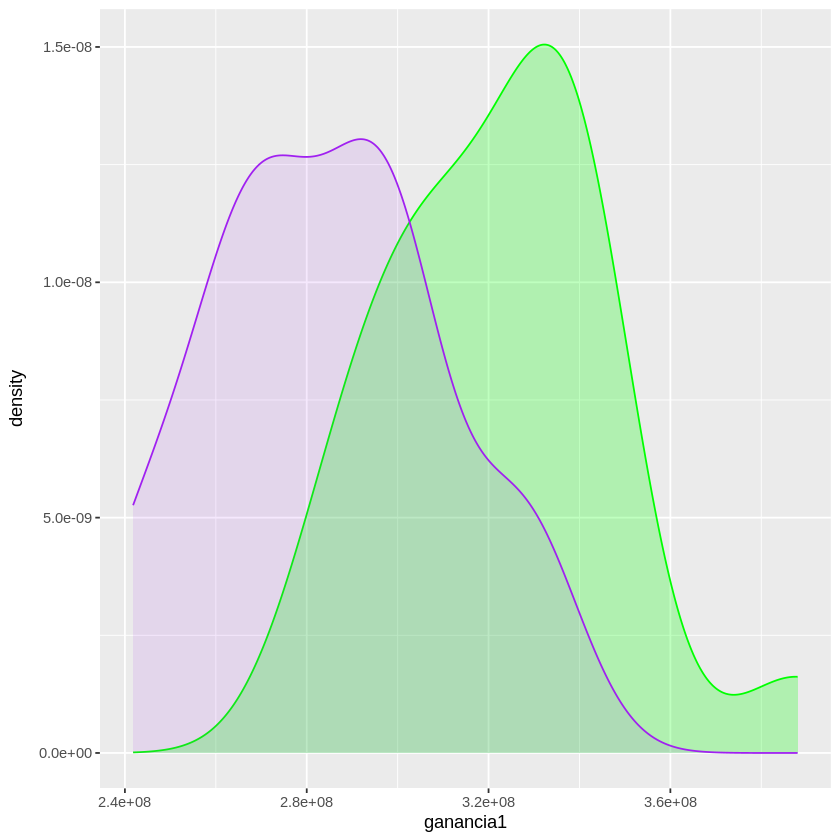

In [70]:
grafico <- ggplot( tb_salida, aes(x=ganancia1)) + geom_density(alpha=0.25, fill="green", color="green")  +
             geom_density(data=tb_salida, aes(x=ganancia2), fill="purple", color="purple",  alpha=0.10)

print(grafico)

In [71]:
# imprimo en un .pdf  que va a la carpeta del experimento
pdf("densidad_dos.pdf")
print(grafico)
dev.off()

agg_record_703580991 
                   2

In [72]:
print( tb_salida[ , list( "arbol1" = mean( ganancia1),  "arbol2" = mean(ganancia2) ) ] )

print( tb_salida[ , list( "prob( m1 > m2)" = sum(ganancia1 > ganancia2 )/ .N ) ]  )

      arbol1    arbol2
       <num>     <num>
1: 322796667 284883333
   prob( m1 > m2)
            <num>
1:              1


### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-dosModelos**
* ¿Todos los alumnos hubieran elegido el mismo modelo aun con 20 semillas?



---



# 6 Comparando dos buenos  modelos
## Clase 02  Experimento 6

## 6.1  Objetivos
Presentar a los alumnos la dificultad que surge en la comparación de dos muy distintos, pero ambos buenos, modelos predictivos, y el costo computacional asociado a esa comparación
<br>Comparación simple de media de ganancias, versus probabilidad que un modelo sea superior a otro.
<br>Limitaciones de la MonteCarlo Cross Validation
<br>Existencia del Test de Wilcoxon

## 6.2 Introduccion
Estos son los dos arboles de muy distinta profundidad.
<br>¿Cuál de ellos es mejor? ¿Cuál elijo?

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --: |  ---: |
| cp | -1 | -1 |
|minsplit | 170 | 1900 |
|minbucket | 70 | 800 |
|maxdepth | 7 | 3 |



## 6.3 Dos buenos modelos

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

El tiempo de corrida es de alrededor de 50 minutos

limpio el ambiente de R

In [73]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1423741,76.1,2538187,135.6,2538187,135.6
Vcells,2675838,20.5,50579726,385.9,103186563,787.3


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [74]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

require("ggplot2")

###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [75]:
PARAM <- list()
PARAM$semilla_primigenia <- 100019
PARAM$qsemillas <- 50
PARAM$training_pct <- 70L     # entre 1 y 100


In [76]:
# los dos arboles
PARAM$rpart1 <- list (
  "cp" = -1,
  "minsplit" = 170,
  "minbucket" = 70,
  "maxdepth" = 7
)


PARAM$rpart2 <- list (
  "cp" = -1,
  "minsplit" = 1900,
  "minbucket" = 800,
  "maxdepth" = 3
)


In [77]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [78]:
DosArbolesEstimarGanancia <- function(semilla, training_pct, param_rpart1, param_rpart2) {
  # fuerzo impresion
  print( paste( semilla, Sys.time()) )
  flush.console()

  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(training_pct, 100L -training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo1 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart1
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion1 <- predict(modelo1, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test1 <- dataset[
    fold == 2,
    sum(ifelse(prediccion1[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada1 <- ganancia_test1 / (( 100 - training_pct ) / 100 )

  modelo2 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart2
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion2 <- predict(modelo2, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test2 <- dataset[
    fold == 2,
    sum(ifelse(prediccion2[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada2 <- ganancia_test2 / (( 100 - training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "ganancia1" = ganancia_test_normalizada1,
    "ganancia2" = ganancia_test_normalizada2
  ))
}

In [79]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp206"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [80]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [81]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia) # inicializo

# me quedo con PARAM$qsemillas   semillas
PARAM$semillas <- sample(primos, PARAM$qsemillas )

In [82]:
# la funcion mcmapply  llama a la funcion DosArbolesEstimarGanancia
#  tantas veces como valores tenga el vector  PARAM$semillas
Sys.time()

salidas <- mcmapply( DosArbolesEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM$training_pct, PARAM$rpart1, PARAM$rpart2), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

Sys.time()

[1] "2025-11-17 01:39:05 UTC"

[1] "2025-11-17 02:44:30 UTC"

In [83]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
tb_salida

semilla,ganancia1,ganancia2
<int>,<dbl>,<dbl>
912523,341266667,325000000
386641,323666667,356666667
251737,343333333,322200000
914533,302733333,327333333
630523,288200000,305066667
402239,306200000,322533333
651913,292000000,290400000
552833,339200000,318066667
583937,281200000,306533333


Warning message in fortify(data, ...):
“Arguments in `...` must be used.
✖ Problematic arguments:
• fill = "green"
• color = "green"
ℹ Did you misspell an argument name?”


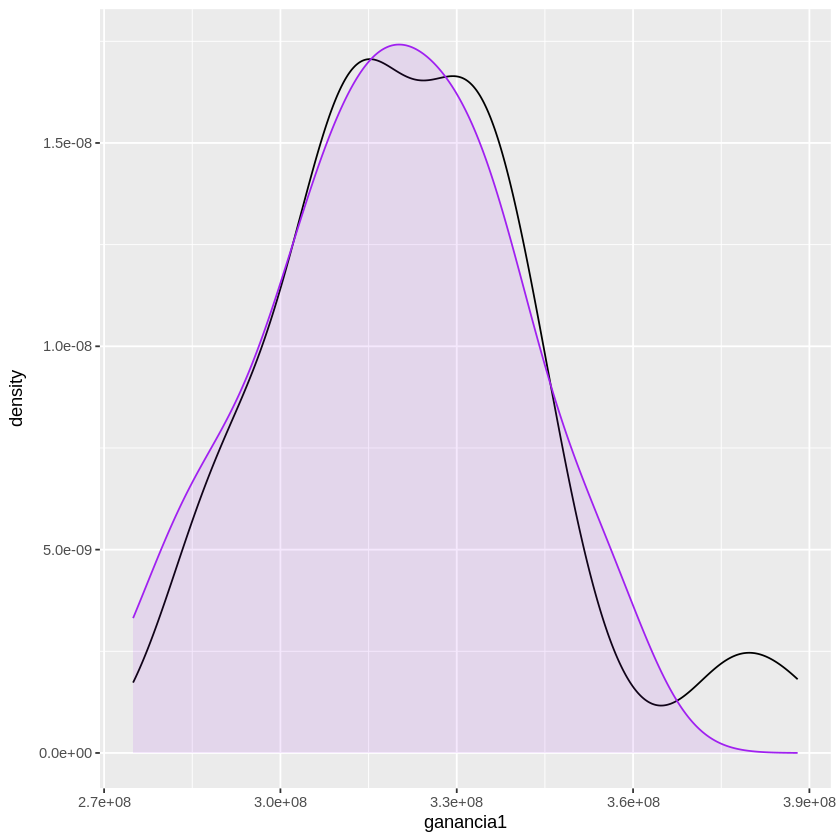

In [84]:
grafico <- ggplot( tb_salida, aes(x=ganancia1), fill="green", color="green") + geom_density(alpha=0.25)  +
             geom_density(data=tb_salida, aes(x=ganancia2), fill="purple", color="purple",  alpha=0.10)

print(grafico)

In [85]:
# imprimo en un .pdf  que va a la carpeta del experimento
pdf("densidad_dos.pdf")
print(grafico)
dev.off()

agg_record_591452226 
                   2

In [86]:
# medias de las ganancias
print( tb_salida[ , list( "arbol1" = mean( ganancia1),  "arbol2" = mean(ganancia2) ) ] )


      arbol1    arbol2
       <num>     <num>
1: 322500000 318738667


In [87]:
# probabilidad que m1 sea mayor a m2
print( tb_salida[ , list( "prob( m1 > m2)" = sum(ganancia1 > ganancia2 )/ .N ) ]  )

   prob( m1 > m2)
            <num>
1:           0.54


### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-dosBuenos**




---



# 7 Test de Wilcoxon
## Clase 02  Experimento 7

## 7.1  Objetivos

¿Como calcular la cantidad mínima de semillas que hacen falta para tener cierta certeza que un modelo es superior a otro?

## 7.2  Introduccion

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --: |  ---: |
| cp | -1 | -1 |
|minsplit | 170 | 250 |
|minbucket | 70 | 125 |
|maxdepth | 7 | 20 |

<br>
<br>



| ordinal | semilla | ganancia1 | ganancia2 | p-value |
| --- | --- |  --- |  --- |  --- |
| 1 |378821 | 301,800,000 | 252,666,667 | 1.000 |
| 2 | 964333  | 314,800,000  | 224,266,667 | 0.500 |
| 3 | 187049 | 326,600,000 | 278,000,000 | 0.250 |
| 4 | 205151 | 299,733,333 | 235,266,667 | 0.125 |
| 5 | 813697 | 275,333,333 | 205,600,000 |  0.063 |
| 6 | 344719 | 290,800,000 | 251,533,333 | 0.031 |
|7 |127217  | 268,200,000 | 219,800,000 |0.016 |
| 8 | 464371 | 271,866,667 | 270,800,000 | 0.008 |
| 9 | 645137 | 252,400,000| 261,733,333 | 0.004|



## 7.3 Codigo Test de Wilcoxon

In [88]:
# 1 sola ganancia
wilcox.test(
  c(301800000),
  c(252666667),
  paired = TRUE
)



	Wilcoxon signed rank exact test

data:  c(301800000) and c(252666667)
V = 1, p-value = 1
alternative hypothesis: true location shift is not equal to 0


In [89]:
# 2 ganancias
wilcox.test(
  c(301800000, 314800000),
  c(252666667, 224266667),
  paired = TRUE
)



	Wilcoxon signed rank exact test

data:  c(301800000, 314800000) and c(252666667, 224266667)
V = 3, p-value = 0.5
alternative hypothesis: true location shift is not equal to 0


In [90]:
# 3 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000),
  c(252666667, 224266667, 278000000),
  paired = TRUE
)


	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000) and c(252666667, 224266667, 2.78e+08)
V = 6, p-value = 0.25
alternative hypothesis: true location shift is not equal to 0


In [91]:
# 4 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000, 299733333),
  c(252666667, 224266667, 278000000, 235266667),
  paired = TRUE
)



	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000, 299733333) and c(252666667, 224266667, 2.78e+08, 235266667)
V = 10, p-value = 0.125
alternative hypothesis: true location shift is not equal to 0


In [92]:
# 5 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000, 299733333, 275333333),
  c(252666667, 224266667, 278000000, 235266667, 205600000),
  paired = TRUE
)


	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000, 299733333, 275333333) and c(252666667, 224266667, 2.78e+08, 235266667, 205600000)
V = 15, p-value = 0.0625
alternative hypothesis: true location shift is not equal to 0


In [93]:
# 6 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000),
  c(252666667, 224266667, 278000000, 235266667, 205600000, 251533333),
  paired = TRUE
)


	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000) and c(252666667, 224266667, 2.78e+08, 235266667, 205600000, 251533333)
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0


In [94]:
# Finalmente el p-value es  0.03125  < 0.05
# hicieron falta  SEIS semillas, seis ganancias, para
#   afirmar que el modelo 1 es superior al modelo 2

# 7 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000, 268200000),
  c(252666667, 224266667, 278000000, 235266667, 205600000, 251533333, 219800000),
  paired = TRUE
)



	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000, 268200000) and c(252666667, 224266667, 2.78e+08, 235266667, 205600000, 251533333, 219800000)
V = 28, p-value = 0.01563
alternative hypothesis: true location shift is not equal to 0


In [95]:
# 8 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000, 268200000, 271866667),
  c(252666667, 224266667, 278000000, 235266667, 205600000, 251533333, 219800000, 270800000),
  paired = TRUE
)



	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000, 268200000, 271866667) and c(252666667, 224266667, 2.78e+08, 235266667, 205600000, 251533333, 219800000, 270800000)
V = 36, p-value = 0.007813
alternative hypothesis: true location shift is not equal to 0


In [96]:
# 9 ganancias
wilcox.test(
  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000, 268200000, 271866667, 252400000),
  c(252666667, 224266667, 278000000, 235266667, 205600000, 251533333, 219800000, 270800000, 261733333),
  paired = TRUE
)


	Wilcoxon signed rank exact test

data:  c(301800000, 314800000, 326600000, 299733333, 275333333, 290800000, 268200000, 271866667, 252400000) and c(252666667, 224266667, 2.78e+08, 235266667, 205600000, 251533333, 219800000, 270800000, 261733333)
V = 43, p-value = 0.01172
alternative hypothesis: true location shift is not equal to 0




---



# 8 Comparando automaticamente modelos con test de Wilcoxon
## Clase 02  Experimento 8

## 8.1  Objetivos

Proveer un script que permita comparar dos arboles de decisión con la librería rpart utilizando la menor cantidad de cómputo que permita el Test de Wilxcoxon

## 8.2  Introduccion

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --- |  --- |
| cp | -1 | -1 |
|minsplit | 1050 | 650 |
|minbucket | 550 | 300 |
|maxdepth |67 | 6 |




## 8.3 Codigo comparacion automatica Wilcoxon

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [97]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1466985,78.4,2538187,135.6,2538187,135.6
Vcells,2740283,21.0,49800653,380.0,103186563,787.3


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [98]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

require("ggplot2")

###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [99]:
PARAM <- list()
PARAM$semilla_primigenia <- 100019
PARAM$qsemillas_tope <- 50
PARAM$training_pct <- 70L     # entre 1 y 100


In [100]:
# los dos arboles
PARAM$rpart1 <- list (
  "cp" = -1,
  "minsplit" = 800,
  "minbucket" = 400,
  "maxdepth" = 7
)


PARAM$rpart2 <- list (
  "cp" = -1,
  "minsplit" = 650,
  "minbucket" = 300,
  "maxdepth" = 6
)


In [101]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [102]:
DosArbolesEstimarGanancia <- function(semilla, training_pct, param_rpart1, param_rpart2) {
  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(training_pct, 100L -training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo1 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart1
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion1 <- predict(modelo1, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test1 <- dataset[
    fold == 2,
    sum(ifelse(prediccion1[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada1 <- ganancia_test1 / (( 100 - training_pct ) / 100 )

  modelo2 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart2
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion2 <- predict(modelo2, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test2 <- dataset[
    fold == 2,
    sum(ifelse(prediccion2[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 780000, -20000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada2 <- ganancia_test2 / (( 100 - training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "ganancia1" = ganancia_test_normalizada1,
    "ganancia2" = ganancia_test_normalizada2
  ))
}

In [103]:
# 1  ->  el modelo 1 es mejor
# 2  ->  el modelo 2 es mejor
# 0  ->  No se pudo determinar con el tope de qsemillas_tope


MejorArbol <- function( qsemillas_tope, training_pct, param_rpart1, param_rpart2) {

  # genero numeros primos
  primos <- generate_primes(min = 100000, max = 1000000)
  set.seed(PARAM$semilla_primigenia) # inicializo
  # me quedo con PARAM$qsemillas   semillas
  semillas <- sample(primos, qsemillas_tope )

  pvalue <- 1.0
  isem <- 1
  vgan1 <- c() # almaceno ganancias del modelo1
  vgan2 <- c() # almaceno ganancias del modelo2

  while( (isem <= qsemillas_tope)  & (pvalue > 0.05) ) {

    res <- DosArbolesEstimarGanancia(
       semillas[ isem ],
       training_pct,
       param_rpart1,
       param_rpart2
    )

    vgan1 <- c( vgan1, res$ganancia1 )
    vgan2 <- c( vgan2, res$ganancia2 )

    wt <- wilcox.test( vgan1, vgan2, paired=TRUE )
    pvalue <- wt$p.value

    cat( isem, res$ganancia1, res$ganancia2, pvalue, "\n" )
    flush.console()
    isem <- isem + 1
  }

  out <- 0

  if( pvalue < 0.05 & mean(vgan1) > mean(vgan2)  )  out <- 1
  if( pvalue < 0.05 & mean(vgan1) < mean(vgan2)  )  out <- 2


  return( list( "out" = out,
    "qsemillas" = length(vgan1),
    "m1" = mean( vgan1 ),
    "m2" = mean( vgan2 )
   ) )
}


In [104]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp209"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [105]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [106]:
Sys.time()

comparacion <- MejorArbol(
   PARAM$qsemillas_tope,
   PARAM$training_pct,
   PARAM$rpart1,
   PARAM$rpart2
 )


print( comparacion )

Sys.time()

[1] "2025-11-17 03:01:29 UTC"

1 312066667 323666667 1 
2 330733333 370466667 0.5 
3 326400000 3.34e+08 0.25 
4 312133333 308133333 0.25 
5 318333333 306600000 0.625 
6 325400000 341400000 0.3125 
7 291933333 303266667 0.21875 
8 327600000 323533333 0.25 
9 340266667 319866667 0.5703125 
10 3.51e+08 376133333 0.3222656 
11 377400000 3.73e+08 0.3652344 
12 350733333 357466667 0.2661133 
13 328600000 320066667 0.3757324 
14 319066667 316133333 0.4262695 
15 338600000 331333333 0.5244751 
16 327800000 341600000 0.3483887 
17 3.12e+08 334533333 0.2068939 
18 317466667 346266667 0.1187057 
19 348466667 331266667 0.2253227 


Warning message in wilcox.test.default(vgan1, vgan2, paired = TRUE):
“cannot compute exact p-value with ties”


20 322333333 325266667 0.2321849 


Warning message in wilcox.test.default(vgan1, vgan2, paired = TRUE):
“cannot compute exact p-value with ties”


21 273866667 330400000 0.1395921 


Warning message in wilcox.test.default(vgan1, vgan2, paired = TRUE):
“cannot compute exact p-value with ties”


22 303333333 343133333 0.08238245 


Warning message in wilcox.test.default(vgan1, vgan2, paired = TRUE):
“cannot compute exact p-value with ties”


23 309866667 353066667 0.04803188 
$out
[1] 2

$qsemillas
[1] 23

$m1
[1] 324582609

$m2
[1] 335243478



[1] "2025-11-17 03:45:49 UTC"

### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-Wilcox**




---

